<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/%D0%9E%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B8%D0%B2%D0%B0%D0%B5%D0%BC_%D0%B8_%D1%81%D1%87%D0%B8%D1%82%D1%8B%D0%B2%D0%B0%D0%B5%D0%BC_%D0%BC%D0%BE%D1%80%D0%B3%D0%B0%D0%BD%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обнаруживаем и считываем моргания


# Detect and read blinks


В этом уроке, на основе полученных данных ранее, научимся обнаруживать и подсчитывать моргание как в готовом видео, так и в режиме реального времени (случай в реальном времени рассматривается отдельно в прикрепленном .py файле)

In this lesson, based on the data obtained earlier, we will learn how to detect and count blinking both in the finished video and in real time (the case in real time separately in the attached .py file)


Здесь мы не будем рассматривать традиционный метод для вычисления мигания, где сперва мы находим глаз, затем определяем белую область глаза и смотрим, когда она пропадет из вида. 

Here we will not consider the traditional method for calculating blinking, where we first find the eye, then determine the white area of the eye and watch when it disappears from view.

Мы будем использовать подход на основе соотношения глаз. 

We will use an eye ratio approach.



> **Соотношение сторон глаза** - это гораздо более элегантное решение, которое включает простой расчет, делая алгоритм намного быстрее и эффективнее. Ключевой момент здесь: между шириной и высотой координат глаза существует связь, которой мы и воспользуемся.

> **Eye Ratio** is a much more elegant solution that involves simple calculation, making the algorithm much faster and more efficient. The key point here: there is a relationship between the width and the height of the coordinates of the eye, which we will use.

Сперва, найдем важные области лица. Из них нас будут интересовать только глаза. Каждый глаз представлен 6 координатами, начиная с левого угла глаза (а далее по часовой стрелке).

First, let's find the important areas of the face. Of these, we will only be interested in the eyes. Each eye is represented by 6 coordinates, starting from the left corner of the eye (and then clockwise).

Полученные координаты мы подставляем в **формулу соотношения сторон глаза (EAR):**

We substitute the obtained coordinates into **the eye aspect ratio (EAR) formula:**


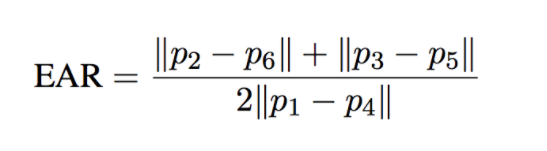

Где **p1-p6** - наши координаты. **Числитель** этого уравнения вычисляет расстояние между вертикальными ориентирами глаза, а **знаменатель** вычисляет расстояние между горизонтальными ориентирами глаза. 

Where **p1-p6** are our coordinates. The **numerator** of this equation calculates the distance between the vertical reference points of the eye, and the **denominator** calculates the distance between the horizontal reference points of the eye.

> При  открытом глазе это соотношение примерно одинаковое всегда, однако, как только глаз закрывается, это значение  быстро падает до нуля.

> When the eye is open, this ratio is always approximately the same, however, as soon as the eye is closed, this value rapidly drops to zero.

Теперь реализуем это все самостоятельно:

Now let's implement it all ourselves:



### Загружаем zip-файл с кодом внутри
### Download the code zip file

In [1]:
!wget http://dataudt.ru/datasets/cv/Lesson_04.Detect_blink.zip
!unzip -qq Lesson_04.Detect_blink.zip
%cd Detect_blink

--2022-02-08 16:14:18--  http://dataudt.ru/datasets/cv/Lesson_04.Detect_blink.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74631977 (71M) [application/zip]
Saving to: ‘Lesson_04.Detect_blink.zip’

Lesson_04.Detect_bl 100%[===================>]  71.17M  16.4MB/s    in 4.6s    

2022-02-08 16:14:23 (15.4 MB/s) - ‘Lesson_04.Detect_blink.zip’ saved [74631977/74631977]

/content/Detect_blink



### Импортируйте необходимые пакеты:
### Import Packages

In [2]:
# импорт необходимых пакетов
# import the necessary packages
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2

### Обнаруживаем моргания с помощью лицевых ориентиров и OpenCV
### Detecting blinks with facial landmarks and OpenCV

In [3]:
def eye_aspect_ratio(eye):
	# вычисляем эвклидовые расстояния между двумя наборами вертикальных глазных ориентиров (x, y)-координат
    # compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	
    # вычисляем эвклидовые расстояния между горизонтальной осью глаза 
    # compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	C = dist.euclidean(eye[0], eye[3])
	
    # вычисляем соотношение сторон глаз
    # compute the eye aspect ratio
	ear = (A + B) / (2.0 * C)
	
    # возвращаем соотношение сторон глаз
    # return the eye aspect ratio
	return ear

In [4]:
# создадим отдельный словарь с аргументами 
# create a separate dictionary with arguments 
args = {
	"shape_predictor": "shape_predictor_68_face_landmarks.dat",
	"video": "blinking.mp4"
}

Для того, чтобы грамотно определить моргание стоит ввести 2 константы: 

In order to correctly determine the blink it is worth introducing 2 constants: 

- **EYE_AR_THRESH** - порог, при котором мы определяем, что данное расположение глаз может быть морганием

- **EYE_AR_THRESH** - the threshold at which we determine that a given eye position can be a blink 

- **EYE_AR_CONSEC_FRAMES** - необходимое кол-во последовательных кадров, где преодолен порог EYE_AR_THRESH,  после которого мы регистрируем данное моргание.





- **EYE_AR_CONSEC_FRAMES** - the necessary number of consecutive frames where the threshold EYE_AR_THRESH is passed, after which we register this blink.



In [5]:
# определяем две константы, одну для соотношения сторон глаза, чтобы указать
# мигает, а затем вторая константа для количества последовательных
# кадра глаз должен быть ниже порога
# define two constants, one for the eye aspect ratio to indicate
# blink and then a second constant for the number of consecutive
# frames the eye must be below the threshold
EYE_AR_THRESH = 0.3 
EYE_AR_CONSEC_FRAMES = 3 

# инициализируем счетчики кадров и общее количество миганий
# initialize the frame counters and the total number of blinks
COUNTER = 0
TOTAL = 0

In [6]:
# инициализируем детектор лиц и предиктор для распознавания лицевых ориентиров
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(args["shape_predictor"])

[INFO] loading facial landmark predictor...


In [7]:
# получим указатели лицевых ориентиров для левого и правого глаза 
# grab the indexes of the facial landmarks for the left and
# right eye, respectively
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [8]:
# запускаем наш видеопоток 
# start the video stream thread
# Здесь мы используем FileVideoStream, так как будем работать уже с готовым видео, а не в режиме реального времени 
# Here we use FileVideoStream, since we will work with the finished video, and not in real time
print("[INFO] starting video stream thread...")
vs = FileVideoStream(args["video"]).start()
fileStream = True

time.sleep(1.0)

# инициализируем указатель на выходной видеофайл
# initialize the pointer to output video file
writer = None

[INFO] starting video stream thread...


In [9]:
# запускаем цикл, пропуская через него все кадры из видеопотока
# loop over frames from the video stream
while True:
    # если мы использовали уже готовое видео, то проверим, не осталось ли еще кадров в буфере для обработки
	# if this is a file video stream, then we need to check if
	# there any more frames left in the buffer to process
	if fileStream and not vs.more():
		break
	
    # берем кадр из потокового видеофайла
	# grab the frame from the threaded video file stream
	frame = vs.read()
	
    # проверяем, есть ли еще кадр
	# check to see if frame is still incoming
	if frame is not None:  
		frame = imutils.resize(frame, width=450) # предварительно обрабатываем кадр, изменяя его размер до нужной ширины 
                                                # pre-process the frame by resizing it to the desired width 
		gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # преобразуем в оттенки серого
                                                        # convert to grayscale
    
    # в противном случае, мы прошлись уже по всему видео 
	# otherwise, we have reached the end of the stream
	else:
		break
	
    # применяем детектор на серое изображение и находим лицо
	# detect faces in the grayscale frame
	rects = detector(gray, 0)
    
    # цикл, в котором мы поочередно проходимся по всем обнаруженным частям лица 
	# loop over the face detections
	for rect in rects:
        # определяем лицевые опорные точки для области лица
        # и преобразовываем полученные координаты (x, y) в массив NumPy
		# determine the facial landmarks for the face region, then
		# convert the facial landmark (x, y)-coordinates to a NumPy
		# array
		shape = predictor(gray, rect)
		shape = face_utils.shape_to_np(shape)
		
        # извлекаем координаты левого и правого глаза, а затем их используем,
        # чтобы вычислить соотношение сторон глаз
		# extract the left and right eye coordinates, then use the
		# coordinates to compute the eye aspect ratio for both eyes
		leftEye = shape[lStart:lEnd]
		rightEye = shape[rStart:rEnd]
		leftEAR = eye_aspect_ratio(leftEye)
		rightEAR = eye_aspect_ratio(rightEye)
		
        # усредняем соотношение сторон глаз 
		# average the eye aspect ratio together for both eyes
		ear = (leftEAR + rightEAR) / 2.0

        # вычисляем корпус для левого и правого глаза, а затем визуализируем для каждого глаза
		# compute the convex hull for the left and right eye, then
		# visualize each of the eyes
		leftEyeHull = cv2.convexHull(leftEye)
		rightEyeHull = cv2.convexHull(rightEye)
		cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
		cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)

        # если полученное соотношение сторон находится  ниже порога мигания, то засчитываем его как возможное моргание
		# check to see if the eye aspect ratio is below the blink
		# threshold, and if so, increment the blink frame counter
		if ear < EYE_AR_THRESH:
			COUNTER += 1
		
        # в противном случае соотношение сторон глаза не ниже моргания порог
		# otherwise, the eye aspect ratio is not below the blink
		# threshold
		else:
            # при открытых глазах мы сравниваем значение нашего счетчика с допустимым порогом, если он преодолен, то считаем это полноценным морганием
			# if the eyes were closed for a sufficient number of
			# then increment the total number of blinks
			if COUNTER >= EYE_AR_CONSEC_FRAMES:
				TOTAL += 1
			
            # при открытии глаз счетчик обнуляем
			# reset the eye frame counter
			COUNTER = 0

        # обновим наш текст, указавши на кадре общее количество морганий вместе с расчетным соотношением сторон глаз для кадра
		# draw the total number of blinks on the frame along with
		# the computed eye aspect ratio for the frame
		cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
			cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
		cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
			cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
 
    # проверяем, существует ли уже VideoWriter, который записывает наше новое видео 
	# check if the video writer is None 
	if writer is None:
        # если нет, то настроим его под нас (указываем в каком формате и куда мы это все будем сохранять) 
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter("output.avi", fourcc, 30,
			(frame.shape[1], frame.shape[0]), True)

    # записываем выходной кадр на диск
	# write the output frame to disk
	writer.write(frame)

# завершаем работу с новым видеофайлом 
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.stop()

[INFO] cleaning up...


Учтите, что код выше требует времени для завершения своего выполнения. Если хотите посмотреть уже на готовое видео, то запустите блоки ниже. 



Note that the code above takes time to complete its execution. If you want to look at the finished video, run the blocks below. 



Наше выходное видео создается в формате **`.avi`**, поэтому нам нужно преобразовать его в формат **`.mp4`**.

Our output video is produced in `.avi` format. First, we need to convert it to `.mp4` format. 

In [10]:
!ffmpeg -i "output.avi" output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [11]:
#@title Display video inline Отображаем видео в режиме реального времени
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)